In [2]:
import pickle
import sys
import csv
import math
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
# from keras import backend as K
import tensorflow as tf
from tensorflow import keras

In [2]:
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
#from keras.applications.vgg16 import VGG16
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
image_h, image_w, image_d = 224,224,3
IMG_SHAPE = (image_h, image_w, image_d)

# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,weights='imagenet', include_top=False)
#base_model.trainable = False
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
'''
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
'''
base_model.summary()

Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooli

In [9]:
def WAR(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)),axis=0) #in catagory
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)),axis=0) #in catagory
    weight = possible_positives/K.sum(possible_positives)
    WAR = K.sum(weight*true_positives/possible_positives)
    
    #weight_1 = possible_positives[0]/K.sum(possible_positives)
    #weight_2 = possible_positives[1]/K.sum(possible_positives)
    #weight_3 = possible_positives[2]/K.sum(possible_positives)
    #recall_ = weight_1*true_positives[0] / (possible_positives[0] + K.epsilon())+weight_2*true_positives[1] / (possible_positives[1] + K.epsilon())+weight_3*true_positives[2] / (possible_positives[2] + K.epsilon())
    return WAR

### Add a classification head

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

add_layer = tf.keras.layers.Dense(64, activation='relu')
add_layer_drop = tf.keras.layers.Dropout(0.25)

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

model = tf.keras.Sequential([base_model,
                             global_average_layer,
                             add_layer,
                             add_layer_drop,
                             prediction_layer])
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adamax(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=[WAR,'accuracy'])
              #weighted_metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 14,747,715
Trainable params: 14,747,715
Non-trainable params: 0
_________________________________________________________________


# Image generator

In [11]:
train_df = pd.read_csv("./train.csv",names=['filename','label'])
#train_df = train_df.replace(['A','B','C'], [0,1,2])
valid_df = pd.read_csv("./dev.csv",names=['filename','label'])
#valid_df = valid_df.replace(['A','B','C'], [0,1,2])

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        featurewise_std_normalization=True,
        rotation_range=10)

test_datagen = ImageDataGenerator(rescale=1./255,featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./Train_224_gb/',
        x_col="filename",
        y_col="label",
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical') #one hot

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='./Dev_224_gb/',
        x_col="filename",
        y_col="label",
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical')

history=model.fit_generator(
        train_generator,
        steps_per_epoch=5600/32,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=800/32)

/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `fe

Found 5600 validated image filenames belonging to 3 classes.
Found 800 validated image filenames belonging to 3 classes.
Epoch 1/12


/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/weichih/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


175/175 [==============================] - 42s 241ms/step - loss: 0.7459 - WAR: 0.5277 - acc: 0.6427 - val_loss: 0.6100 - val_WAR: 0.6637 - val_acc: 0.7113
Epoch 2/12
175/175 [==============================] - 42s 238ms/step - loss: 0.5727 - WAR: 0.7113 - acc: 0.7448 - val_loss: 0.5455 - val_WAR: 0.7500 - val_acc: 0.7750
Epoch 3/12
175/175 [==============================] - 42s 241ms/step - loss: 0.5341 - WAR: 0.7398 - acc: 0.7650 - val_loss: 0.5666 - val_WAR: 0.7262 - val_acc: 0.7462
Epoch 4/12
175/175 [==============================] - 43s 245ms/step - loss: 0.5224 - WAR: 0.7495 - acc: 0.7720 - val_loss: 0.5451 - val_WAR: 0.7325 - val_acc: 0.7675
Epoch 5/12
175/175 [==============================] - 43s 246ms/step - loss: 0.5148 - WAR: 0.7546 - acc: 0.7777 - val_loss: 0.4890 - val_WAR: 0.7788 - val_acc: 0.7925
Epoch 6/12
175/175 [==============================] - 43s 243ms/step - loss: 0.4869 - WAR: 0.7734 - acc: 0.7930 - val_loss: 0.4654 - val_WAR: 0.7950 - val_acc: 0.8050
Epoch 7/1

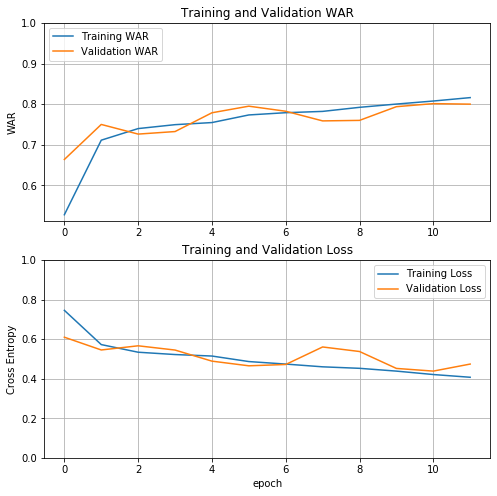

In [12]:
# graph
#model.evaluate(data_d,tag_l)
acc = history.history['WAR']
val_acc = history.history['val_WAR']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training WAR')
plt.plot(val_acc, label='Validation WAR')
plt.legend(loc='upper left')
plt.ylabel('WAR')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation WAR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [13]:
#graph
val_acc

[0.66375,
 0.75,
 0.72625,
 0.7325,
 0.77875,
 0.795,
 0.7825,
 0.75875,
 0.76,
 0.79375,
 0.80125,
 0.8]

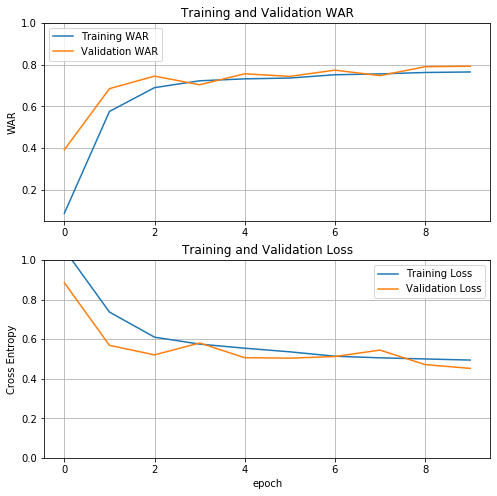

In [33]:
# canny
#model.evaluate(data_d,tag_l)
acc = history.history['WAR']
val_acc = history.history['val_WAR']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training WAR')
plt.plot(val_acc, label='Validation WAR')
plt.legend(loc='upper left')
plt.ylabel('WAR')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation WAR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [35]:
#canny
val_acc

[0.3925,
 0.685,
 0.745,
 0.70375,
 0.75625,
 0.74375,
 0.77375,
 0.7475,
 0.79,
 0.7925]

# Training

In [102]:

initial_epochs = 10
validation_steps=20
validation_split = 0.2
#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = validation_split)
datagen.fit(data)
history = model.fit_generator(datagen.flow(data, tag, batch_size=32,shuffle=True,subset="training"),
                    steps_per_epoch=len(data)*(1-validation_split) / 32, epochs=initial_epochs)#,validation_split=0.2)
#history = model.fit(data,tag,epochs=initial_epochs,validation_split=0.1)
model.evaluate(data_d,tag_l)

Epoch 1/10
140/140 [==============================] - 33s 239ms/step - loss: 0.7733 - WAR: 0.5087
Epoch 2/10
140/140 [==============================] - 32s 230ms/step - loss: 0.6137 - WAR: 0.7063
Epoch 3/10
140/140 [==============================] - 32s 231ms/step - loss: 0.5660 - WAR: 0.7315
Epoch 4/10
140/140 [==============================] - 32s 230ms/step - loss: 0.5429 - WAR: 0.7455
Epoch 5/10
140/140 [==============================] - 32s 229ms/step - loss: 0.4998 - WAR: 0.7616
Epoch 6/10
140/140 [==============================] - 32s 229ms/step - loss: 0.4848 - WAR: 0.7763
Epoch 7/10
140/140 [==============================] - 32s 228ms/step - loss: 0.4517 - WAR: 0.7920
Epoch 8/10
140/140 [==============================] - 32s 229ms/step - loss: 0.4211 - WAR: 0.8141
Epoch 9/10
140/140 [==============================] - 32s 229ms/step - loss: 0.3952 - WAR: 0.8281
Epoch 10/10
800/800 [==============================] - 3s 3ms/sample - loss: 0.6329 - WAR: 0.6662


[0.632867968082428, 0.66625]

In [77]:
tag_l

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

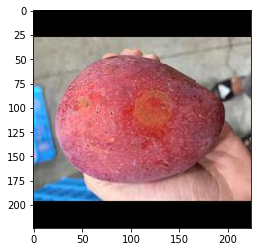

In [80]:
plt.imshow(data_d[2])
plt.show()

<tf.Tensor 'clip_by_value:0' shape=() dtype=float32>

# Train 

In [6]:
filelist =glob.glob('/home/weichih/wei/mango/Train_224/*.jpg')
filelist = sorted(filelist,key=lambda name: int(name[35:-4])) 
data = []
for f1 in filelist:
    img = cv2.imread(f1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    data.append(img/255)
data = np.array(data)

with open('/home/weichih/wei/mango/train.csv', newline='') as csvfile:
    labels = list(csv.reader(csvfile))
tag = [row[1] for row in labels]
for i,ele in enumerate(tag):
    if ele == 'A':
        tag[i] = 0
    elif ele == 'B':
        tag[i] = 1
    elif ele == 'C':
        tag[i] = 2        

tag = np.array(tag)
tag = np_utils.to_categorical(tag, 3)

image_num = data.shape[0]
image_h = data.shape[1]
image_w = data.shape[2]
image_d = data.shape[3]
number_cat = tag.shape[1]

IndexError: tuple index out of range

# Dev

In [62]:
filelist =glob.glob('/home/weichih/wei/mango/Dev_224/*.jpg')
filelist = sorted(filelist,key=lambda name: int(name[33:-4])) 
data_d = []
for f1 in filelist:
    img = cv2.imread(f1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    data_d.append(img/255)
data_d = np.array(data_d)
with open('/home/weichih/wei/mango/dev.csv', newline='') as csvfile:
    labels_dev = list(csv.reader(csvfile))
tag_l = [row[1] for row in labels_dev]
for i,ele in enumerate(tag_l):
    if ele == 'A':
        tag_l[i] = 0
    elif ele == 'B':
        tag_l[i] = 1
    elif ele == 'C':
        tag_l[i] = 2        

tag_l = np.array(tag_l)
tag_l = np_utils.to_categorical(tag_l, 3)
'''
image_num_d = data_d.shape[0]
image_h_d = data_d.shape[1]
image_w_d = data_d.shape[2]
image_d_d = data_d.shape[3]
number_cat_d = tag_l.shape[1]

dev_image = tf.placeholder(dtype=tf.float32, shape=[image_num_d,image_h_d ,image_w_d,image_d_d])
dev_label = tf.placeholder(dtype=tf.float32, shape=[image_num_d,number_cat_d])
shuffle_size = 32
batch_size = 32
#repeat_size = 2
#dataset = tf.data.Dataset.from_tensor_slices((train_image,train_label))
validation_batches = tf.data.Dataset.from_tensor_slices((dev_image,dev_label)).batch(batch_size)

validation_batches, validation_labels = tf.train.shuffle_batch(
      [dev_image, dev_label],
      batch_size=32,
      num_threads=4,
      capacity=50000,
      min_after_dequeue=10000)
'''

'\nimage_num_d = data_d.shape[0]\nimage_h_d = data_d.shape[1]\nimage_w_d = data_d.shape[2]\nimage_d_d = data_d.shape[3]\nnumber_cat_d = tag_l.shape[1]\n\ndev_image = tf.placeholder(dtype=tf.float32, shape=[image_num_d,image_h_d ,image_w_d,image_d_d])\ndev_label = tf.placeholder(dtype=tf.float32, shape=[image_num_d,number_cat_d])\nshuffle_size = 32\nbatch_size = 32\n#repeat_size = 2\n#dataset = tf.data.Dataset.from_tensor_slices((train_image,train_label))\nvalidation_batches = tf.data.Dataset.from_tensor_slices((dev_image,dev_label)).batch(batch_size)\n\nvalidation_batches, validation_labels = tf.train.shuffle_batch(\n      [dev_image, dev_label],\n      batch_size=32,\n      num_threads=4,\n      capacity=50000,\n      min_after_dequeue=10000)\n'

In [91]:
model.evaluate(data_d,tag_l)

800/800 [==============================] - 3s 3ms/sample - loss: 0.5590 - WAR: 0.7475


[0.5589783596992492, 0.7475]

In [2]:
import sys

In [4]:
sys.executable

'/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8'